In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import zipfile
from skimage.filters import laplace, sobel
import os
import cv2
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
#Estrazione dei file nell'ambiente Colab
image_data = zipfile.ZipFile('/content/gdrive/MyDrive/Digital/archive.zip')
image_data.extractall()
image_data.close()

# MobileNet

Import the necessary libraries for CNNs

In [ ]:
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import numpy as np

import random as python_random

from tensorflow.keras import layers

Split the dataset into 70% training set, 20% validation set and 10% test set

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('blur_dataset_scaled', output="output", seed=1337, ratio=(0.7, 0.2, 0.1))

Copying files: 1050 files [00:02, 415.51 files/s]


Set the seeds for the different libraries:

In [ ]:
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

Create directories for train, validation and test sets:

In [ ]:
path_train='/content/output/train/'
path_val='/content/output/val/'
path_test='/content/output/test/'

The *image_dataset_from_directory* function (used in the following chunk) expects a folder with as many subfolders as the number of classes. Inside each subfolder, all the images of that specific class.
Data shuffling (randomization of the instances order) is fundamental just for the train set in order to ensure that each minibatch is representative of the whole set of classes (or as many classes as possible)

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(path_train,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=True,
                                                            seed=1)

val_dataset = keras.preprocessing.image_dataset_from_directory(path_val,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=False,
                                                            seed=1)

test_dataset = keras.preprocessing.image_dataset_from_directory(path_test,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=False,
                                                            seed=1)

Found 732 files belonging to 3 classes.
Found 210 files belonging to 3 classes.
Found 108 files belonging to 3 classes.


We disabled shuffling for the test data:
It is not needed because it does not impact the training procedure.
It would make evaluation (comparison between ground truth and prediction) more difficult.

Different functionalities:
* 'Train' refers to the training set for our model.
*   'Validation' refers to an annotated dataset that is not used for training. It will be used to perform hyperparameter optimization, for example changing the learning rate or regularizer values based on the performance that we observe on the validation set.
*   'Test' refers to a final dataset on which we test the model performance.

Check for the number of classes in the train dataset:

In [ ]:
class_names = train_dataset.class_names
print(class_names)

['defocused_blurred', 'motion_blurred', 'sharp']


In [ ]:
num_classes=3

## Iteration on number of dense nodes



Here is the description of the main features of the first network implemented below:

* Complex structure using transfer learning: instead of training the model from scratch, we use weights pre-trained on a different task, specifically leveraging MobileNet.
* Loop over the number of nodes in the second to last dense layer: we iterate over different numbers of nodes in the penultimate dense layer, starting from 128, then 256, and finally 512, to explore the model with the best performance.
* Dropout set to 10% on the dense layer: Dropout is applied at a rate of 10% on the dense layer, randomly inhibiting 10% of the weights of the dense layer at each iteration of the network.
* BatchNormalization before the dense layers: BatchNormalization is employed before the dense layers to normalize the activations and accelerate the training process.
* L2 regularizer to penalize the weights: L2 regularizer is applied to penalize the weights of the network in the activation function, promoting smoother weight distributions and mitigating overfitting.
* EarlyStopping with patience limited to 5 epochs.

**Objective:** The objective is to assess whether starting from a complex network, using transfer learning, and adding a GlobalAveragePooling layer for feature extraction along with a dense layer yields good results on the validation set.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Definisci il numero di nodi nel layer denso finale per ogni allenamento
num_nodes = [128, 256, 512]

# Lista per memorizzare le storie di addestramento per ogni allenamento
historiesAdamdense = []
evaluate_testAdamdense=[]

# Definisco il termine di regularizer migliore

best_regularizerAdam = 0.001
best_learningrAdam= 0.001

# Definisci il percorso dei dati
data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# Ciclo su diversi numeri di nodi nel layer denso finale

for nodes in num_nodes:
    # Crea il modello
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    regularization = tf.keras.regularizers.l2(best_regularizerAdam)
    x = inputs
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(nodes, activation='relu',kernel_regularizer=best_regularizerAdam)(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model1 = Model(inputs=inputs, outputs=predictions)
    optimizer = Adam(learning_rate=best_learningrAdam)
    model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model1.summary()
    # Addestra il modello
    historyAdam = model1.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=[callback]
    )

    # Aggiungi la storia di addestramento alla lista
    historiesAdamdense.append(historyAdam)
    #evaluation
    evaluate = loss, accuracy = model1.evaluate(test_generator)

    evaluate_testAdamdense.append(evaluate)

Found 732 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
17225924/17225924 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
     

In [ ]:
table_data = {'Dense': num_nodes, 'Loss Diff Mean': [], 'Accuracy Diff Mean': []}

for i, history in enumerate(historiesAdamdense):
    dense = num_nodes[i]
    train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)
    avg_loss_diff_text = f'Loss Diff: {avg_loss_diff:.4f}'

    train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)
    avg_acc_diff_text = f'Accuracy Diff: {avg_acc_diff:.4f}'


    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)


table_df = pd.DataFrame(table_data)


print(table_df.to_string(index=False, float_format='%.4f'))

 Dense  Loss Diff Mean  Accuracy Diff Mean
   128          0.4354              0.1730
   256          0.4259              0.1706
   512          0.5639              0.1794


Mean Loss Difference (Loss Diff Mean):
* Increasing the number of nodes in the penultimate dense layer (128 → 256 → 512) tends to increase the average loss. This suggests that models with a higher number of nodes may be more complex and may have a greater tendency to overfit.
* Mean Accuracy Difference (Accuracy Diff Mean):
The average accuracy remains relatively similar across different numbers of nodes in the penultimate dense layer. However, it's important to note that there are no significant improvements in accuracy by increasing the number of nodes. This might indicate that adding additional nodes does not lead to significant benefits in terms of predictive performance.

Plot of the Accuracies and Losses corresponsing to train and validation set varying the number of nodes in the second to last layer:

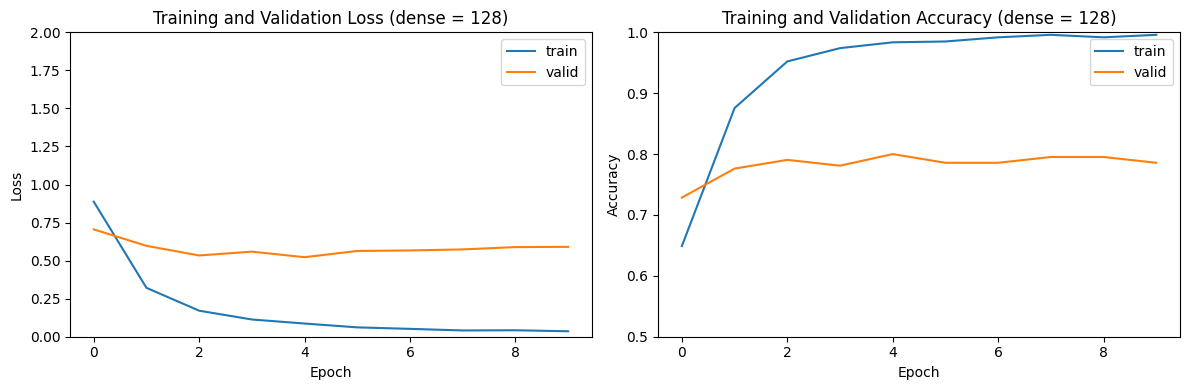

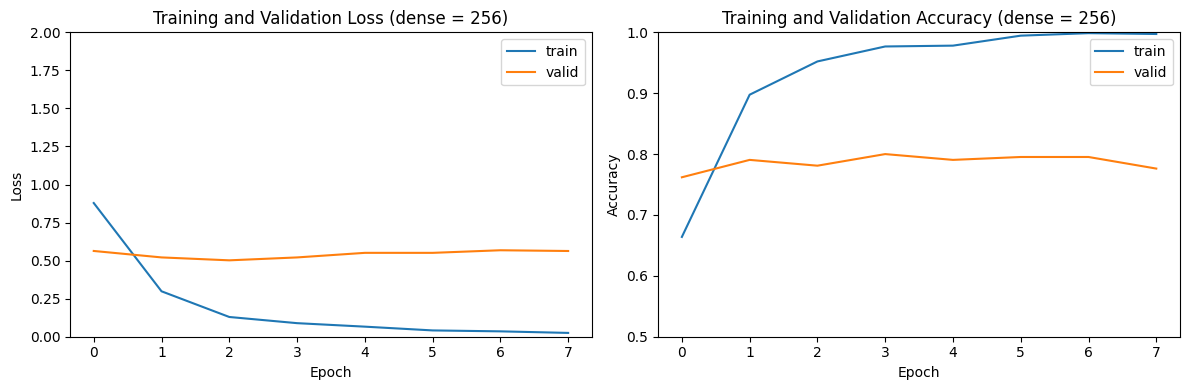

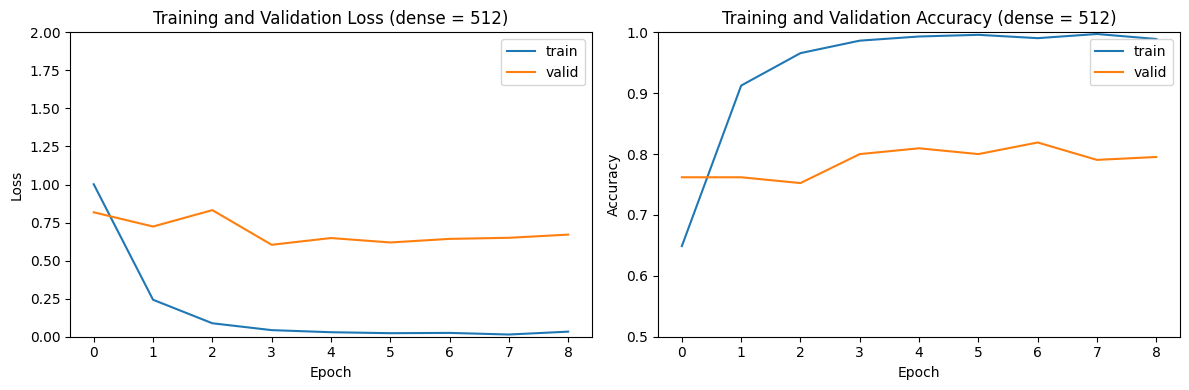

In [ ]:
for i, history in enumerate(historiesAdamdense):
    dense = num_nodes[i]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid' ])
    plt.title(f'Training and Validation Loss (dense = {dense})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (dense = {dense})');

    plt.tight_layout()
    plt.show()


We notice that the model tends to overfit. We will adopt techniques to try to mitigate this phenomenon

Final comparison between the three performances on validation set:

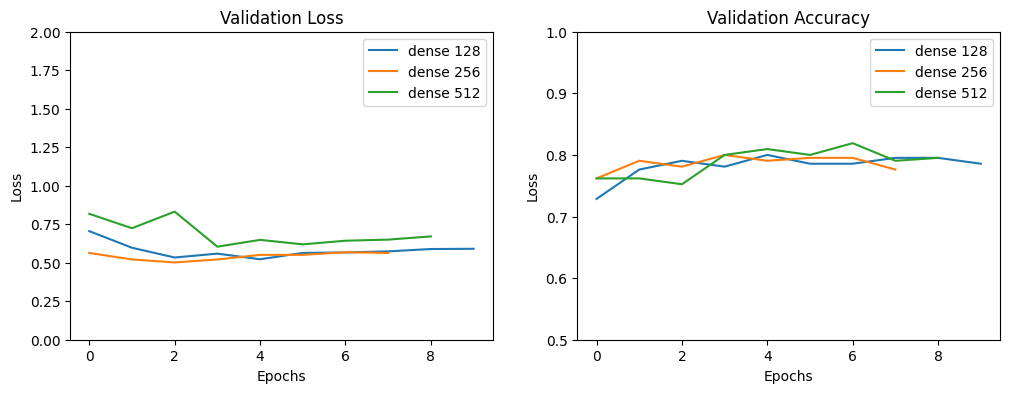

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

for i, history in enumerate(historiesAdamdense):
    plt.plot(history.history['val_loss'], label='dense {}'.format(num_nodes[i]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
for i, history in enumerate(historiesAdamdense):
    plt.plot(history.history['val_accuracy'], label='dense {}'.format(num_nodes[i]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy')
plt.legend()


From the reported graphs, it is evident that training the model with the 512 node layer results in higher loss values compared to the other two on the validation set. Specifically, we believe that a good compromise is represented by the network with 128 nodes in the dense layer, even if the results do not significantly differ from those obtained with 64 dense nodes.

Second network implementation:
* Ciclying on the range of possibe nodes: 128,256,512
* Try to avoid overfitting by reducing the network complexity, increasing the Dropout value (from 0.1 to 0.5)



### Evaluation test set

In [ ]:
print(evaluate_testAdamdense)

[[0.40463128685951233, 0.8425925970077515], [0.3403358459472656, 0.8611111044883728], [0.4143950641155243, 0.8703703880310059]]


## Dropout = 0.5

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Definisci il numero di nodi nel layer denso finale per ogni allenamento
num_nodes = [128, 256, 512]

# Lista per memorizzare le storie di addestramento per ogni allenamento
historiesAdamdense_05 = []
evaluate_testAdamdense_05=[]

# Definisco il termine di regularizer migliore

best_regularizerAdam = 0.001
best_learningrAdam= 0.001
# Definisci il percorso dei dati

data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# Ciclo su diversi numeri di nodi nel layer denso finale

for nodes in num_nodes:
    # Crea il modello
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    regularization = tf.keras.regularizers.l2(best_regularizerAdam)
    x = inputs
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(nodes, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model2 = Model(inputs=inputs, outputs=predictions)
    optimizer = Adam(learning_rate=best_learningrAdam)
    model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model2.summary()
    # Addestra il modello
    historyAdam = model2.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=[callback]
    )

    # Aggiungi la storia di addestramento alla lista
    historiesAdamdense_05.append(historyAdam)
    #evaluation
    evaluate = loss, accuracy = model2.evaluate(test_generator)

    evaluate_testAdamdense_05.append(evaluate)

Found 732 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_3 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 d

In [ ]:
table_data = {'Dense': num_nodes, 'Loss Diff Mean': [], 'Accuracy Diff Mean': []}

for i, history in enumerate(historiesAdamdense_05):
    dense = num_nodes[i]
    train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)
    avg_loss_diff_text = f'Loss Diff: {avg_loss_diff:.4f}'

    train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)
    avg_acc_diff_text = f'Accuracy Diff: {avg_acc_diff:.4f}'


    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)


table_df = pd.DataFrame(table_data)


print(table_df.to_string(index=False, float_format='%.4f'))

 Dense  Loss Diff Mean  Accuracy Diff Mean
   128          0.2647              0.1176
   256          0.3040              0.1114
   512          0.3973              0.1431


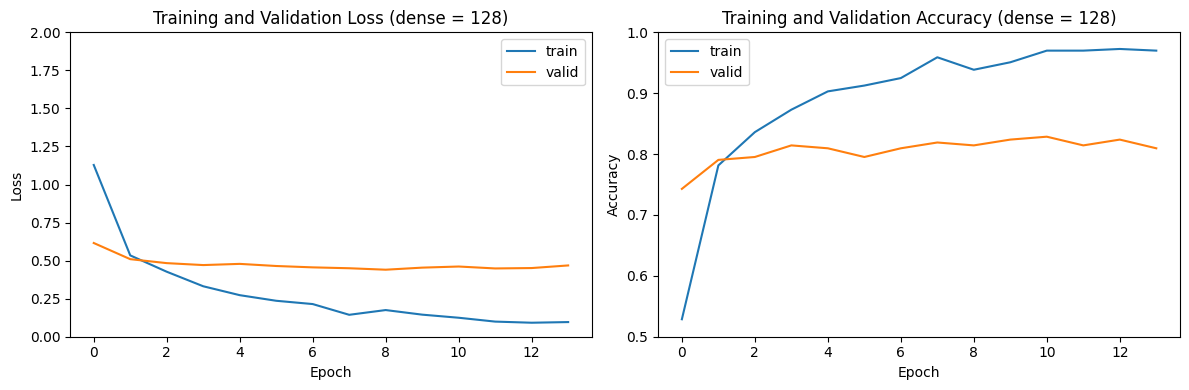

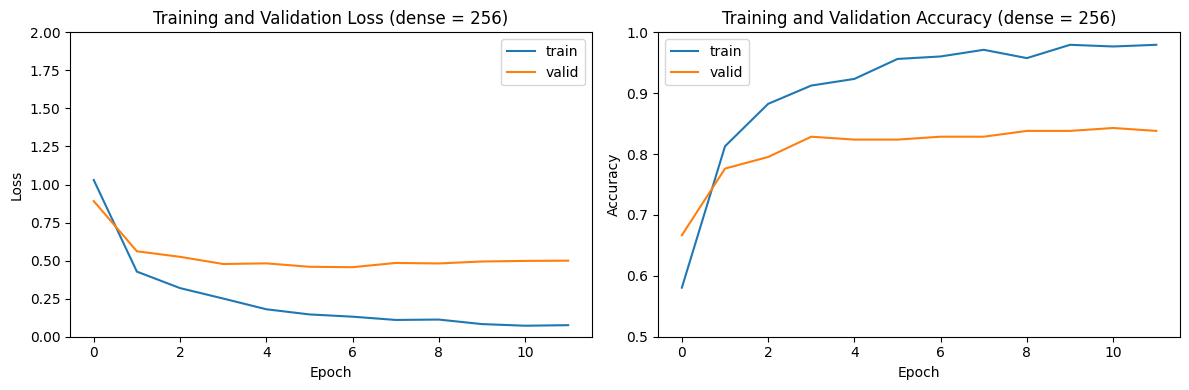

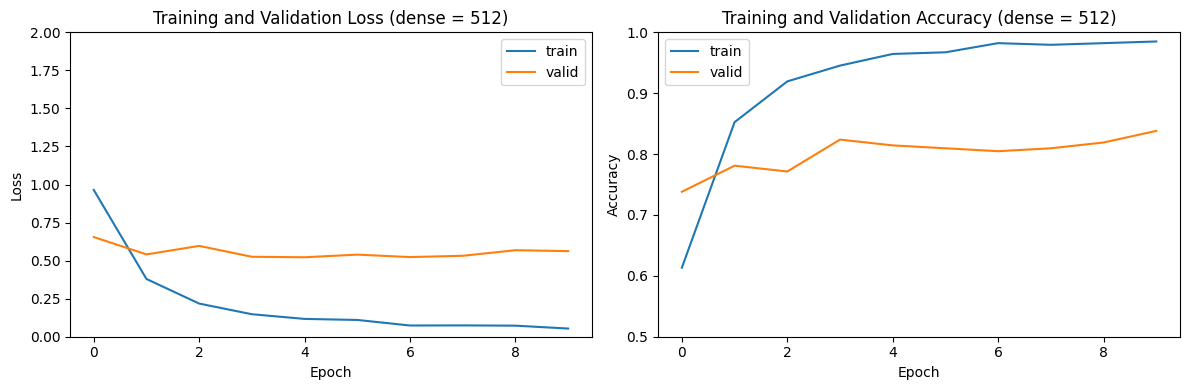

In [ ]:
for i, history in enumerate(historiesAdamdense_05):
    dense = num_nodes[i]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid' ])
    plt.title(f'Training and Validation Loss (dense = {dense})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (dense = {dense})');

    plt.tight_layout()
    plt.show()


### Evaluation test set

In [ ]:
print(evaluate_testAdamdense_05)

[[0.3069038391113281, 0.9166666865348816], [0.30464956164360046, 0.8888888955116272], [0.3606944680213928, 0.8796296119689941]]


Compared to the results in the first table, we observe a decrease in the values. This suggests that the gap between training and validation accuracy, as well as between training and validation loss, has been reduced. This could imply that overfitting has been mitigated. However, we have not seen a significant improvement in performance on the validation set compared to the previous network. Indeed, the accuracy on the validation set hovers around 80%, while the loss does not drop below 0.5. However, there is a clear improvement in loss for the model with 512 nodes in the penultimate dense layer, transitioning from values around 0.75 to values that settle just above 0.5

## Regularizer 0.01

To mitigate overfitting, we try increasing the value of the regularizer from 0.001 to 0.01 (fixing dropout to 0.5):

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
   test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

evaluate_testAdamdense_001=[]

# Definisco il termine di regularizer migliore e il learning rate

best_regularizerAdam = 0.01
best_learningrAdam= 0.001


batch_size = 32

# Crea il modello
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
regularization = tf.keras.regularizers.l2(best_regularizerAdam)
x = inputs
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(nodes, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model3 = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(learning_rate=best_learningrAdam)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()
# Addestra il modello
historyAdam = model3.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
)


#evaluation
evaluate = loss, accuracy = model3.evaluate(test_generator)

evaluate_testAdamdense_001.append(evaluate)

Found 732 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_6  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_9 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 d

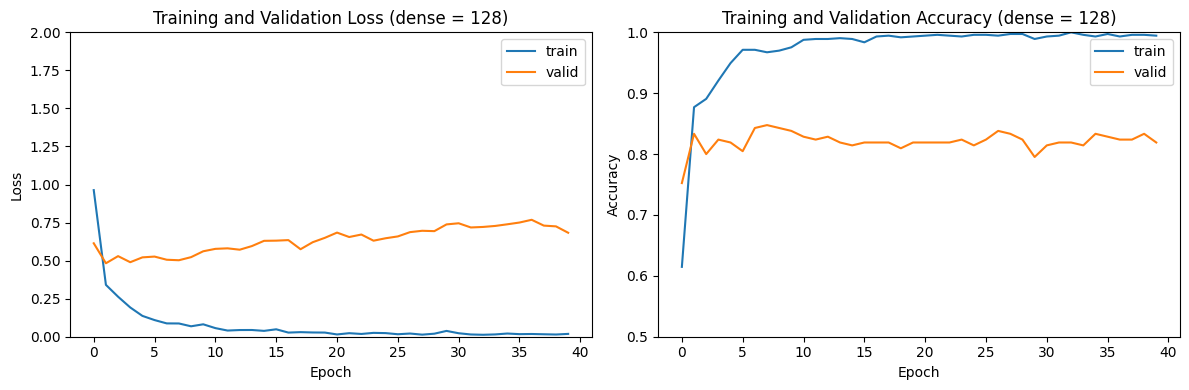

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyAdam.history['loss'])
plt.plot(historyAdam.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss (dense = {128})');


plt.subplot(1, 2, 2)
plt.plot(historyAdam.history['accuracy'])
plt.plot(historyAdam.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy (dense = {128})');

plt.tight_layout()
plt.show()

### Evaluation test set

In [ ]:
print(evaluate_testAdamdense_001)

[[0.5201688408851624, 0.8611111044883728]]


## Learning rate from 0.001 to 0.0001

To mitigate overfitting, we try decreasing the learning rate from 0.001 to 0.0001 (fixing the regularizer to the high value of 0.01 as before and dropout to 0.5)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
#callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


evaluate_testAdamdense_0001=[]

# Definisco il termine di regularizer migliore

best_regularizerAdam = 0.01
best_learningrAdam= 0.0001

# Crea il modello
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
regularization = tf.keras.regularizers.l2(best_regularizerAdam)
x = inputs
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(nodes, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model4 = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(learning_rate=best_learningrAdam)
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()
# Addestra il modello
historyAdam = model4.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
)

#evaluation
evaluate = loss, accuracy = model4.evaluate(test_generator)

evaluate_testAdamdense_0001.append(evaluate)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_7  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_11 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 512)               524800    
                                                           

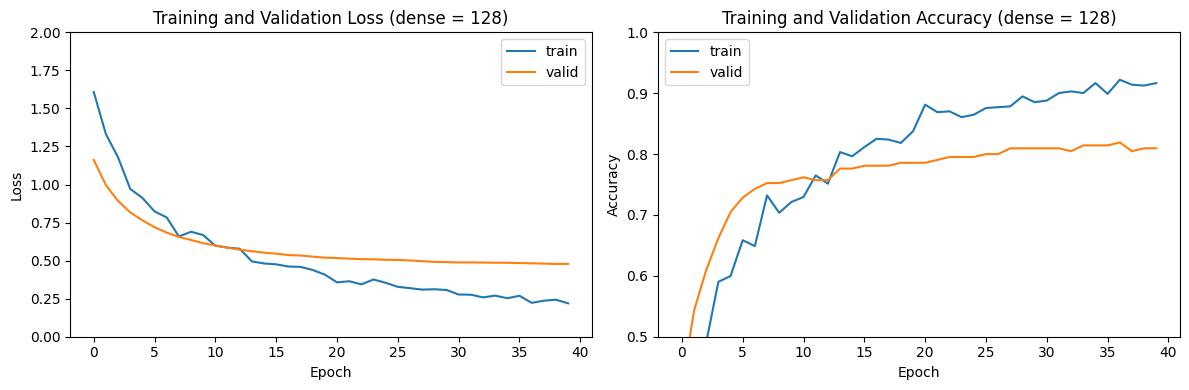

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyAdam.history['loss'])
plt.plot(historyAdam.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss (dense = {128})');


plt.subplot(1, 2, 2)
plt.plot(historyAdam.history['accuracy'])
plt.plot(historyAdam.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy (dense = {128})');

plt.tight_layout()
plt.show()


From the plot above we can see a better generalization: reducing the learning rate results in better generalization on validation data. A smaller learning rate helps the model converge towards a solution that is more general and less dependent on the training data (smoothing convergence to the solution and the gap between triain andvalidation set is lower). However the accuracy value remains around 0.8 values, getting its maximum a t 0.8143 on the validation set.

Risk of getting stuck in local minima. However, too small of a learning rate might also increase the risk of the optimizer getting stuck in local minima or saddle points, significantly slowing down convergence or preventing training progress altogether. In fact this could be the reason why we do not get higher accuracy values.

The model fits well with test data

### Evaluation test set

In [ ]:
print(evaluate_testAdamdense_0001)

[[0.34589120745658875, 0.8796296119689941]]


## Augmentation

Try two different two different types of augmentation


*   First augmentation: position and portion based
*   Second augmentation: Color based



In [ ]:
data_augmentation_1 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomCrop(height=224, width=224),  # Aggiunta del crop
    ]
)

def random_channel_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

data_augmentation_2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.GaussianNoise(0.1),
        layers.Lambda(random_channel_flip),

    ]
)

First augmentation-Implementation of the newtwork using:

* 128 nodes for the second to last desnse layer
* Regularizer 0.01 and learning rate 0.0001. (This choice is driven by our preference for greater generalization capability rather than a higher accuracy value).

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


evaluate_testAdamdense_aug1=[]

# Definisco il termine di regularizer migliore

best_regularizerAdam = 0.01
best_learningrAdam= 0.0001
# Definisci il percorso dei dati

data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
regularization = tf.keras.regularizers.l2(best_regularizerAdam)
x = inputs
x = data_augmentation_1(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model5 = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(learning_rate=best_learningrAdam)
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()
# Addestra il modello
historyAdam = model5.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator
    )

#evaluation
evaluate = loss, accuracy = model5.evaluate(test_generator)

evaluate_testAdamdense_aug1.append(evaluate)

Found 732 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_8  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_13 (Ba  (None, 1024)              4096      
 t

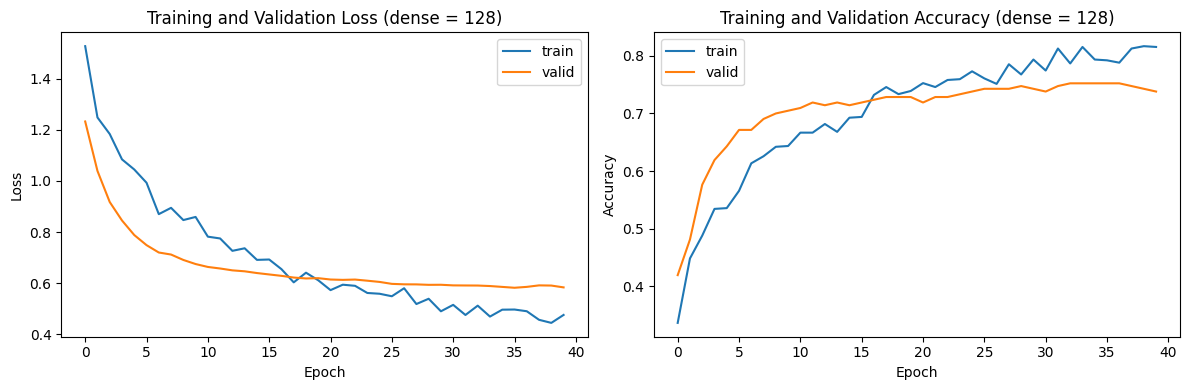

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyAdam.history['loss'])
plt.plot(historyAdam.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss (dense = {128})');


plt.subplot(1, 2, 2)
plt.plot(historyAdam.history['accuracy'])
plt.plot(historyAdam.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy (dense = {128})');

plt.tight_layout()
plt.show()

### Evaluation test set of the first data augmentation implementation

In [ ]:
print(evaluate_testAdamdense_aug1)

[[0.454405814409256, 0.7777777910232544]]


Implementation of the neural network using the second augmentation function:

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

evaluate_testAdamdense_aug2=[]

# Definisco il termine di regularizer migliore

best_regularizerAdam = 0.01
best_learningrAdam= 0.0001
# Definisci il percorso dei dati

data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# Ciclo su diversi numeri di nodi nel layer denso finale

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
regularization = tf.keras.regularizers.l2(best_regularizerAdam)
x = inputs
x = data_augmentation_2(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model6 = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(learning_rate=best_learningrAdam)
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model6.summary()
# Addestra il modello
historyAdam = model6.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator
    )

#evaluation
evaluate = loss, accuracy = model6.evaluate(test_generator)

evaluate_testAdamdense_aug2.append(evaluate)

Found 732 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 c

### Evaluation test set of the second data augmentation implementation

In [ ]:
print(evaluate_testAdamdense_aug2)

[[3.78401780128479, 0.39814814925193787]]


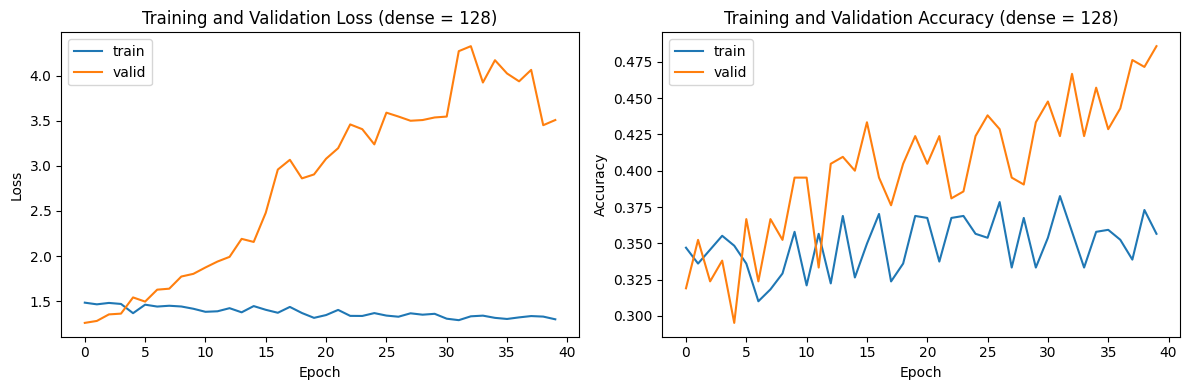

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyAdam.history['loss'])
plt.plot(historyAdam.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss (dense = {128})');


plt.subplot(1, 2, 2)
plt.plot(historyAdam.history['accuracy'])
plt.plot(historyAdam.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy (dense = {128})');

plt.tight_layout()
plt.show()

The network performs better with the first data augmentation, as it is natural to think since the classification of the images does not depend on color but on other shape-related characteristics. However, the performance obtained with data augmentation is not better than the results reported in the first part of our work.





## Adding dense layers

First implementation:
128 nodes in the dense layer

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

evaluate_testAdamdense128_nodes=[]

best_regularizerAdam = 0.01
best_learningrAdam= 0.0001

batch_size = 32
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# Aggiunta di ulteriori layer Dense e BatchNormalization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

predictions = Dense(num_classes, activation='softmax')(x)
model7 = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(learning_rate=best_learningrAdam)
model7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model7.summary()
historyAdam1 = model7.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
)
evaluate = loss, accuracy = model7.evaluate(test_generator)
evaluate_testAdamdense128_nodes.append(evaluate)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_10 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                           

### Evaluation test set (128 nodes)

In [ ]:
print(evaluate_testAdamdense128_nodes)

[[0.3389071822166443, 0.8611111044883728]]


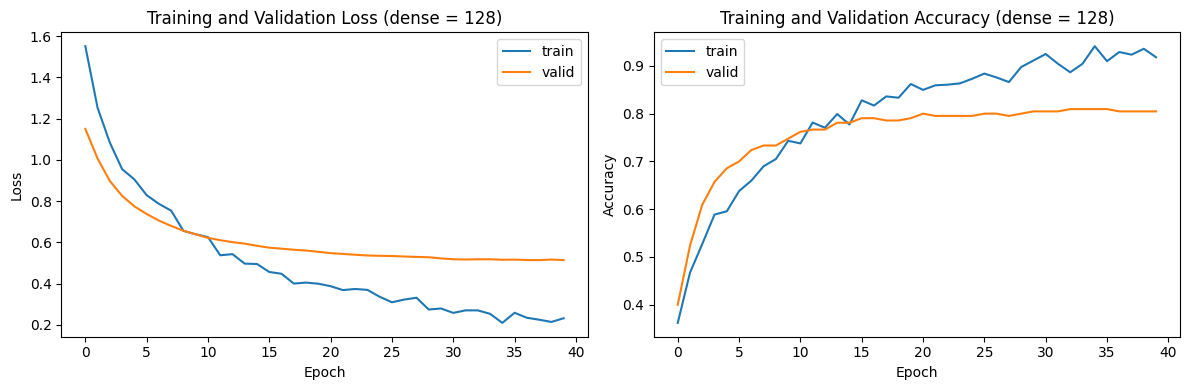

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyAdam1.history['loss'])
plt.plot(historyAdam1.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss (dense = {128})');


plt.subplot(1, 2, 2)
plt.plot(historyAdam1.history['accuracy'])
plt.plot(historyAdam1.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy (dense = {128})');

plt.tight_layout()
plt.show()

The above neural network has been optimized adding Dense layers and BatchNormalization:

```
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
```
between GlobalAveragePooling and the second to last dense layer:


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
   test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 732 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 108 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

evaluate_testAdamdense256_nodes=[]

best_regularizerAdam = 0.01
best_learningrAdam= 0.0001

batch_size = 32

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# Aggiunta di ulteriori layer Dense e BatchNormalization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

predictions = Dense(num_classes, activation='softmax')(x)
model8 = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(learning_rate=best_learningrAdam)
model8.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model8.summary()
historyAdam2 = model8.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
)

evaluate = loss, accuracy = model8.evaluate(test_generator)
evaluate_testAdamdense256_nodes.append(evaluate)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_9 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                           

### Evaluation test set (128+256 nodes)

In [ ]:
print(evaluate_testAdamdense256_nodes)

[[0.37190768122673035, 0.8148148059844971]]


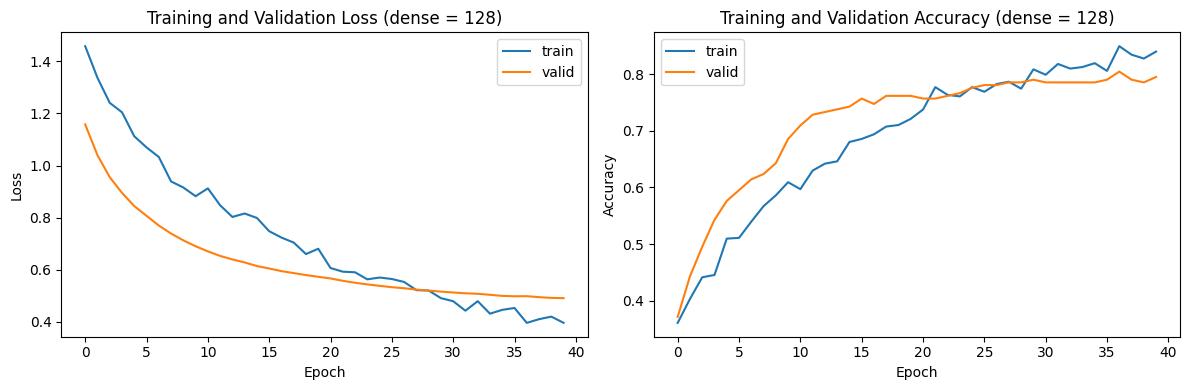

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyAdam2.history['loss'])
plt.plot(historyAdam2.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss (dense = {128})');


plt.subplot(1, 2, 2)
plt.plot(historyAdam2.history['accuracy'])
plt.plot(historyAdam2.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy (dense = {128})');

plt.tight_layout()
plt.show()

The neural network above has been implemented by adding the folloqing dense layers and BatchNormalization:

```
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
```
between GlobalAveragePooling and the second to last dense layer:

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

evaluate_testAdamdense512_nodes=[]

best_regularizerAdam = 0.01
best_learningrAdam= 0.0001

batch_size = 32

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)

# Aggiunta di ulteriori layer Dense e BatchNormalization
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)

model9 = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(learning_rate=best_learningrAdam)
model9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model9.summary()

historyAdam3 = model9.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
)

evaluate = loss, accuracy = model9.evaluate(test_generator)
evaluate_testAdamdense512_nodes.append(evaluate)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                           

### Evaluation test set (128+256+512 nodes)

In [ ]:
print(evaluate_testAdamdense512_nodes)

[[0.2985980808734894, 0.8981481194496155]]


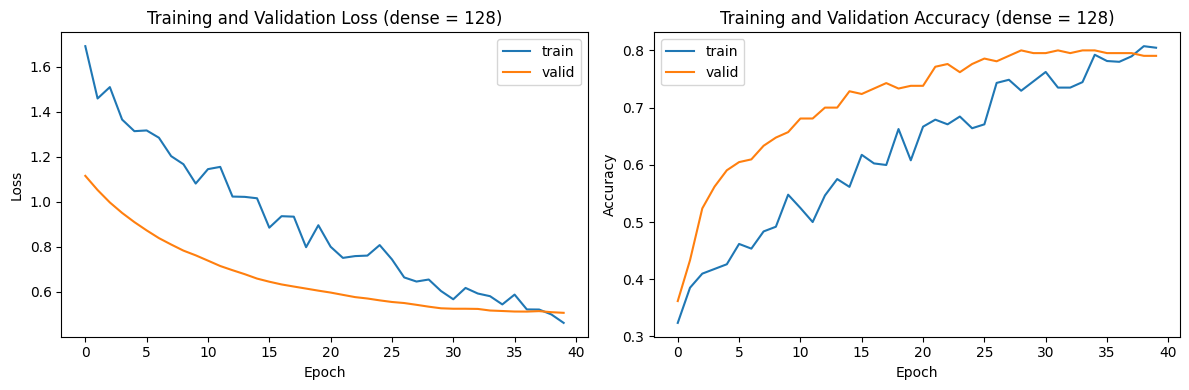

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyAdam3.history['loss'])
plt.plot(historyAdam3.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss (dense = {128})');


plt.subplot(1, 2, 2)
plt.plot(historyAdam3.history['accuracy'])
plt.plot(historyAdam3.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy (dense = {128})');

plt.tight_layout()
plt.show()

Try Maxpooling layers

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

num_nodes = [128]
# Lista per memorizzare le storie di addestramento per ogni allenamento
historiesAdamdense = []
evaluate_testAdamdense=[]

# Definisco il termine di regularizer migliore

best_regularizerAdam = 0.001
best_learningrAdam= 0.001
# Definisci il percorso dei dati

data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
batch_size = 32

for nodes in num_nodes:
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Modifiche ai layer
    x = inputs
    x = base_model(x)

    x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.GlobalMaxPooling2D()(x)

    # Fine modifiche


    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    optimizer = Adam(learning_rate=best_learningrAdam)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    historyAdam = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
    )

    historiesAdamdense.append(historyAdam)
    evaluate = loss, accuracy = model.evaluate(test_generator)
    evaluate_testAdamdense.append(evaluate)


Found 732 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          294944    
                                                                 
 activation (Activation)     (None, 7, 7, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
  

In [ ]:
print(evaluate_testAdamdense)

[[0.5043479204177856, 0.8796296119689941]]


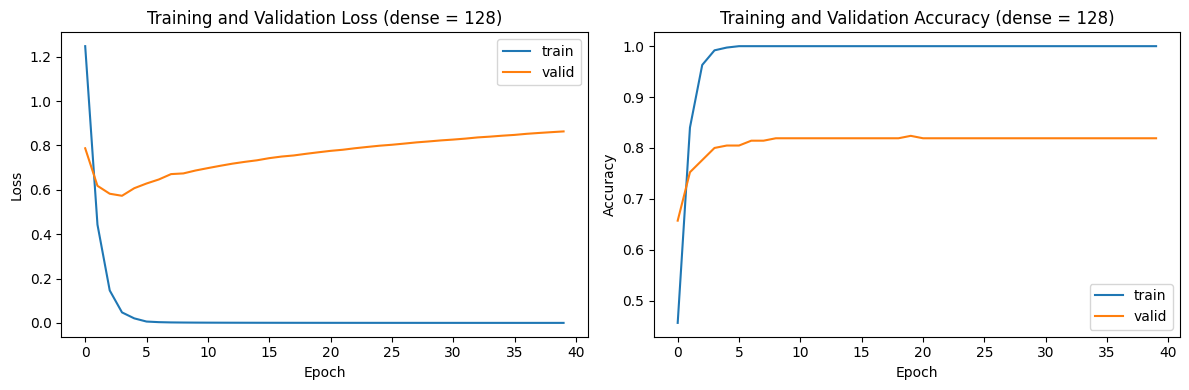

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyAdam.history['loss'])
plt.plot(historyAdam.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss (dense = {128})');


plt.subplot(1, 2, 2)
plt.plot(historyAdam.history['accuracy'])
plt.plot(historyAdam.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy (dense = {128})');

plt.tight_layout()
plt.show()

The network is subjected to overfitting

## Maxpooling layer + GlobalAveragePooling Layer network

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

num_nodes = [128]
historiesAdamdense = []
evaluate_testAdamdense=[]

best_learningrAdam = 0.001

data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

for kernel_size in [3, 5, 7]:
    for stride in [1, 2]:
        for nodes in num_nodes:
            base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
            for layer in base_model.layers:
                layer.trainable = False
            inputs = tf.keras.Input(shape=(224, 224, 3))

            x = base_model(inputs)

            x = tf.keras.layers.Conv2D(32, kernel_size, strides=stride, padding='same')(x)
            x = tf.keras.layers.Activation('relu')(x)
            x = tf.keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

            x = tf.keras.layers.Conv2D(64, kernel_size, strides=stride, padding='same')(x)
            x = tf.keras.layers.Activation('relu')(x)

            x = tf.keras.layers.GlobalMaxPooling2D()(x)

            predictions = Dense(num_classes, activation='softmax')(x)

            model = Model(inputs=inputs, outputs=predictions)
            optimizer = Adam(learning_rate=best_learningrAdam)
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
            model.summary()

            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            historyAdam = model.fit(
                train_generator,
                epochs=40,
                validation_data=val_generator,
                callbacks=[early_stopping]
            )

            historiesAdamdense.append(historyAdam)
            evaluate = loss, accuracy = model.evaluate(test_generator)
            evaluate_testAdamdense.append(evaluate)



Found 732 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          294944    
                                                                 
 activation (Activation)     (None, 7, 7, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)  

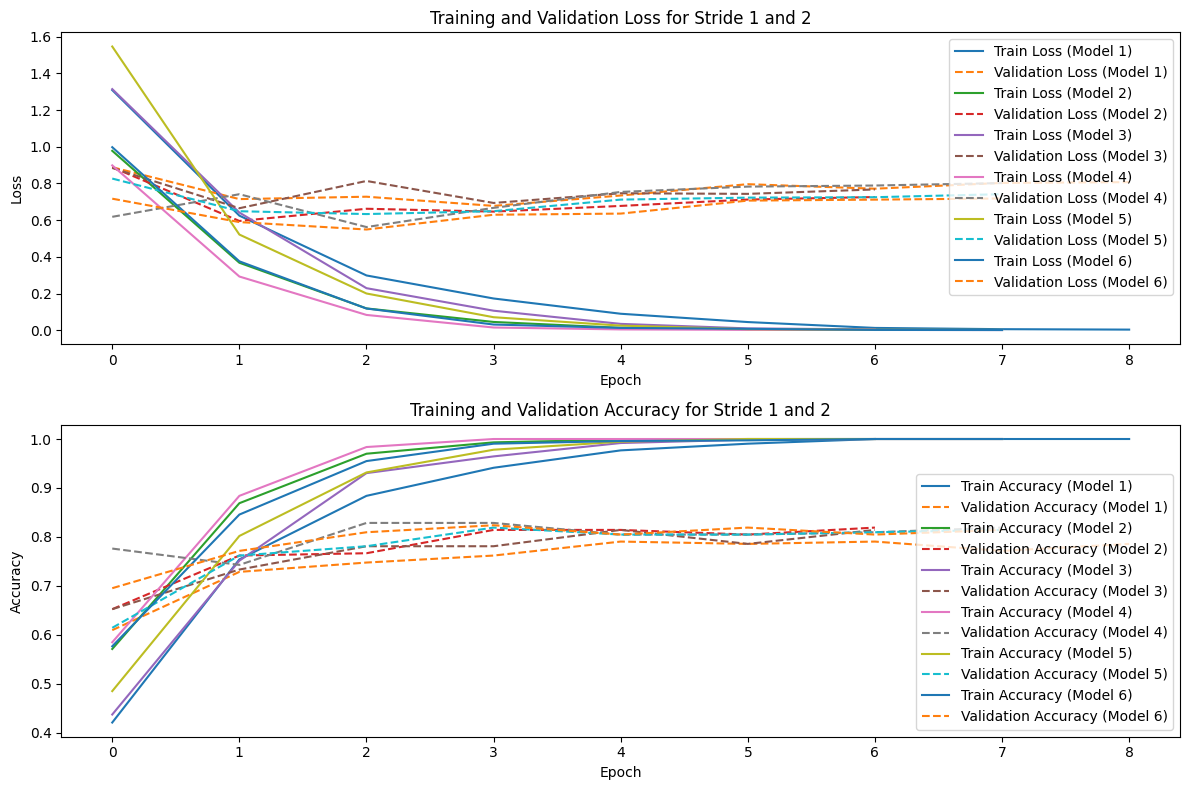

In [ ]:
import matplotlib.pyplot as plt

# Plot loss e accuracy su train e validation per stride 1
plt.figure(figsize=(12, 8))

# Plot loss su train e validation
plt.subplot(2, 1, 1)
for i, history in enumerate(historiesAdamdense):
    plt.plot(history.history['loss'], linestyle='-', label=f'Train Loss (Model {i+1})')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'Validation Loss (Model {i+1})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for Stride 1 and 2')

# Plot accuracy su train e validation
plt.subplot(2, 1, 2)
for i, history in enumerate(historiesAdamdense):
    plt.plot(history.history['accuracy'], linestyle='-', label=f'Train Accuracy (Model {i+1})')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'Validation Accuracy (Model {i+1})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for Stride 1 and 2')

plt.tight_layout()
plt.show()

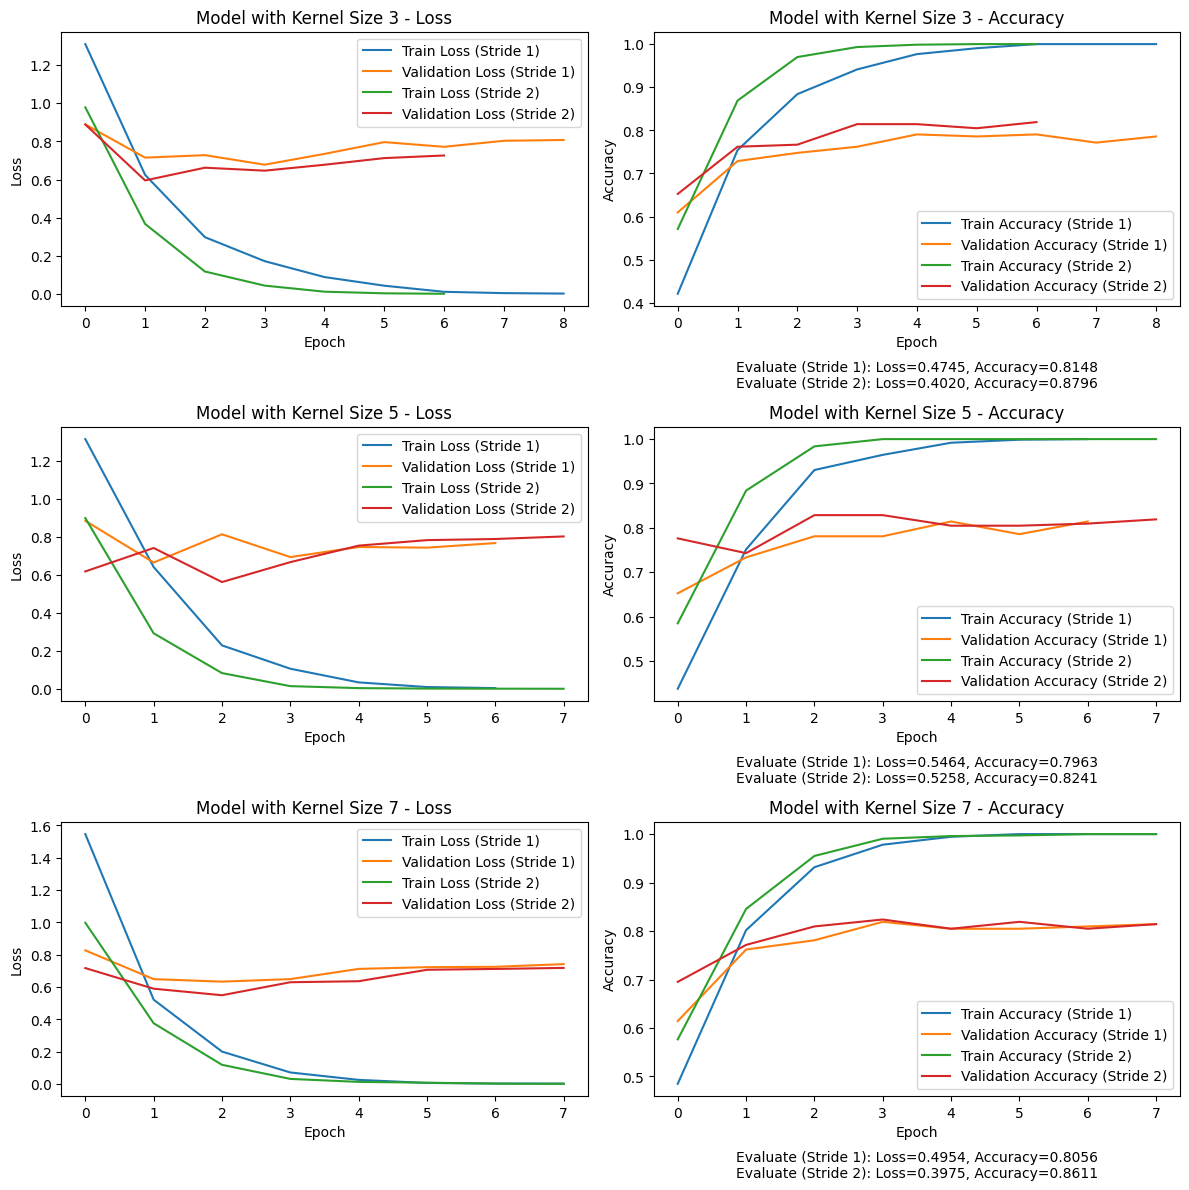

In [ ]:
import matplotlib.pyplot as plt

# Lista dei kernel sizes
kernel_sizes = [3, 5, 7]

# Creazione dei grafici
fig, axes = plt.subplots(len(kernel_sizes), 2, figsize=(12, len(kernel_sizes) * 4))

for i, kernel_size in enumerate(kernel_sizes):
    model_idx = i

    # Indice corrispondente alla storia dell'allenamento per il kernel size corrente
    history_idx = i * 2

    # Plot loss su train e validation per il kernel size corrente e stride 1
    axes[model_idx, 0].plot(historiesAdamdense[history_idx].history['loss'], label='Train Loss (Stride 1)')
    axes[model_idx, 0].plot(historiesAdamdense[history_idx].history['val_loss'], label='Validation Loss (Stride 1)')

    # Plot loss su train e validation per il kernel size corrente e stride 2
    axes[model_idx, 0].plot(historiesAdamdense[history_idx + 1].history['loss'], label='Train Loss (Stride 2)')
    axes[model_idx, 0].plot(historiesAdamdense[history_idx + 1].history['val_loss'], label='Validation Loss (Stride 2)')

    axes[model_idx, 0].set_xlabel('Epoch')
    axes[model_idx, 0].set_ylabel('Loss')
    axes[model_idx, 0].set_title(f'Model with Kernel Size {kernel_size} - Loss')
    axes[model_idx, 0].legend()

    # Plot accuracy su train e validation per il kernel size corrente e stride 1
    axes[model_idx, 1].plot(historiesAdamdense[history_idx].history['accuracy'], label='Train Accuracy (Stride 1)')
    axes[model_idx, 1].plot(historiesAdamdense[history_idx].history['val_accuracy'], label='Validation Accuracy (Stride 1)')

    # Plot accuracy su train e validation per il kernel size corrente e stride 2
    axes[model_idx, 1].plot(historiesAdamdense[history_idx + 1].history['accuracy'], label='Train Accuracy (Stride 2)')
    axes[model_idx, 1].plot(historiesAdamdense[history_idx + 1].history['val_accuracy'], label='Validation Accuracy (Stride 2)')

    axes[model_idx, 1].set_xlabel('Epoch')
    axes[model_idx, 1].set_ylabel('Accuracy')
    axes[model_idx, 1].set_title(f'Model with Kernel Size {kernel_size} - Accuracy')
    axes[model_idx, 1].legend()

    # Stampa dei valori di evaluate
    evaluate_1 = evaluate_testAdamdense[history_idx]
    evaluate_2 = evaluate_testAdamdense[history_idx + 1]
    axes[model_idx, 1].text(0.5, -0.25, f'Evaluate (Stride 1): Loss={evaluate_1[0]:.4f}, Accuracy={evaluate_1[1]:.4f}\nEvaluate (Stride 2): Loss={evaluate_2[0]:.4f}, Accuracy={evaluate_2[1]:.4f}',
                             horizontalalignment='center', verticalalignment='center', transform=axes[model_idx, 1].transAxes)


plt.tight_layout()
plt.show()


The main reason for preferring GlobalAveragePooling2D over MaxPooling2D in this context is related to the difference in the retained information. While MaxPooling2D extracts the most relevant features from each region of the feature map, GlobalAveragePooling2D calculates the average of all features.

In the case of image classification, GlobalAveragePooling2D tends to preserve more generalized information about the entire image, rather than focusing only on the most relevant features. This is particularly useful when dealing with pre-trained neural networks like MobileNet, where features extracted from earlier stages of the network are already quite informative and generalized.

Additionally, GlobalAveragePooling2D can help reduce the risk of overfitting compared to MaxPooling2D, as it reduces the number of trainable parameters in the model. This can help avoid overly complex modeling and promote better generalization to new data.


## Best Overall Result

the best-performing model based on the obtained results has:

* Dropout rate: 0.5
* Regularization parameter: 0.01
* Learning rate: 0.0001
* Dense layers: 3 dense layers with decreasing number of nodes (512, 256, 128)
* Batch normalization layers: 3 batch normalization layers
* Globalmaxpooling layer after the pre-training phase

This model configuration yielded the best performance based on the evaluation results, in particular yielding the lowest value of loss on the test set.

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

evaluate_testAdamdense512_nodes=[]

best_regularizerAdam = 0.01
best_learningrAdam= 0.0001

batch_size = 32

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)

# Aggiunta di ulteriori layer Dense e BatchNormalization
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)

model9 = Model(inputs=inputs, outputs=predictions)
optimizer = Adam(learning_rate=best_learningrAdam)
model9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model9.summary()

historyAdam3 = model9.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
)

evaluate = loss, accuracy = model9.evaluate(test_generator)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_4 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                           

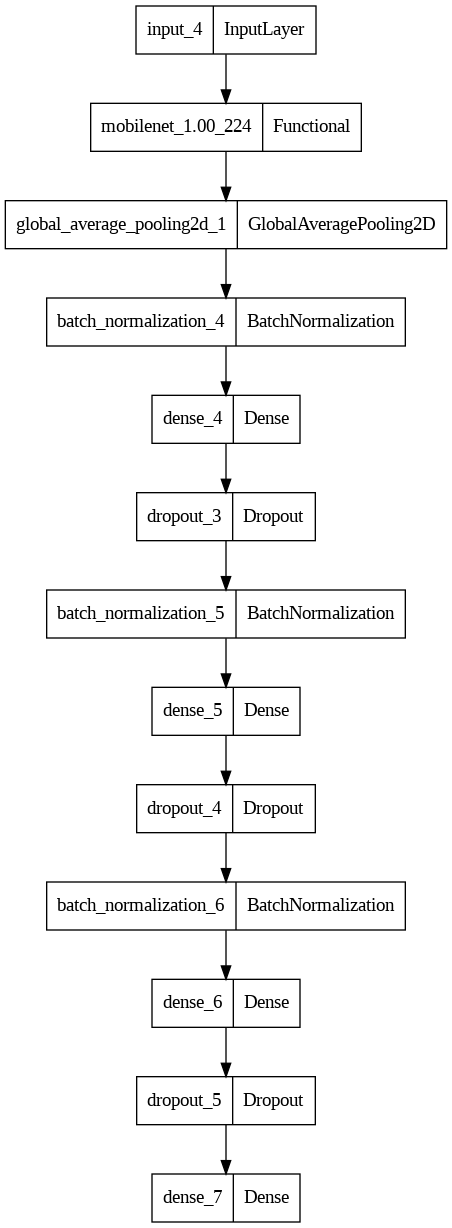

In [ ]:
keras.utils.plot_model(model9, to_file="MobileNet.png")

In [ ]:
print(evaluate)

[0.35088402032852173, 0.8333333134651184]


In [ ]:
model9.save('/content/gdrive/MyDrive/Digital/MobileNet.h5')

In [ ]:
num_images_test = test_generator.n
print("Number of images in the test generator:", num_images_test)


Number of images in the test generator: 108


In [ ]:
class_labels = list(test_generator.class_indices.keys())
print(class_labels)

['defocused_blurred', 'motion_blurred', 'sharp']


In [ ]:
predictions = model9.predict(test_generator)

4/4 [==============================] - 7s 1s/step


1/1 [==============================] - 1s 1s/step
12
1/1 [==============================] - 4s 4s/step
44
1/1 [==============================] - 3s 3s/step
76
1/1 [==============================] - 2s 2s/step
108
Numero di immagini classificate erroneamente: 11
Numero totale di immagini: 108
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        34
           1       0.87      0.89      0.88        37
           2       0.94      0.92      0.93        37

    accuracy                           0.90       108
   macro avg       0.90      0.90      0.90       108
weighted avg       0.90      0.90      0.90       108



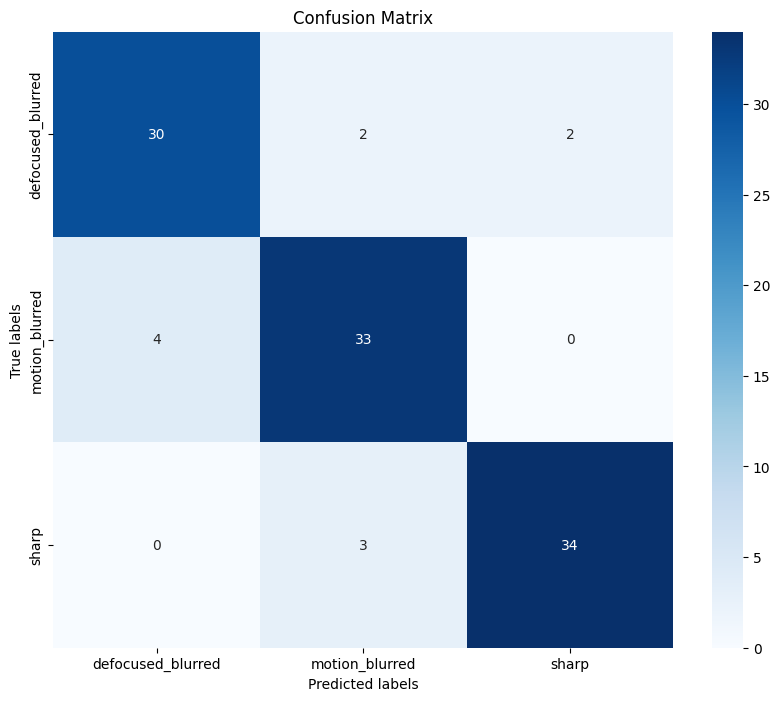

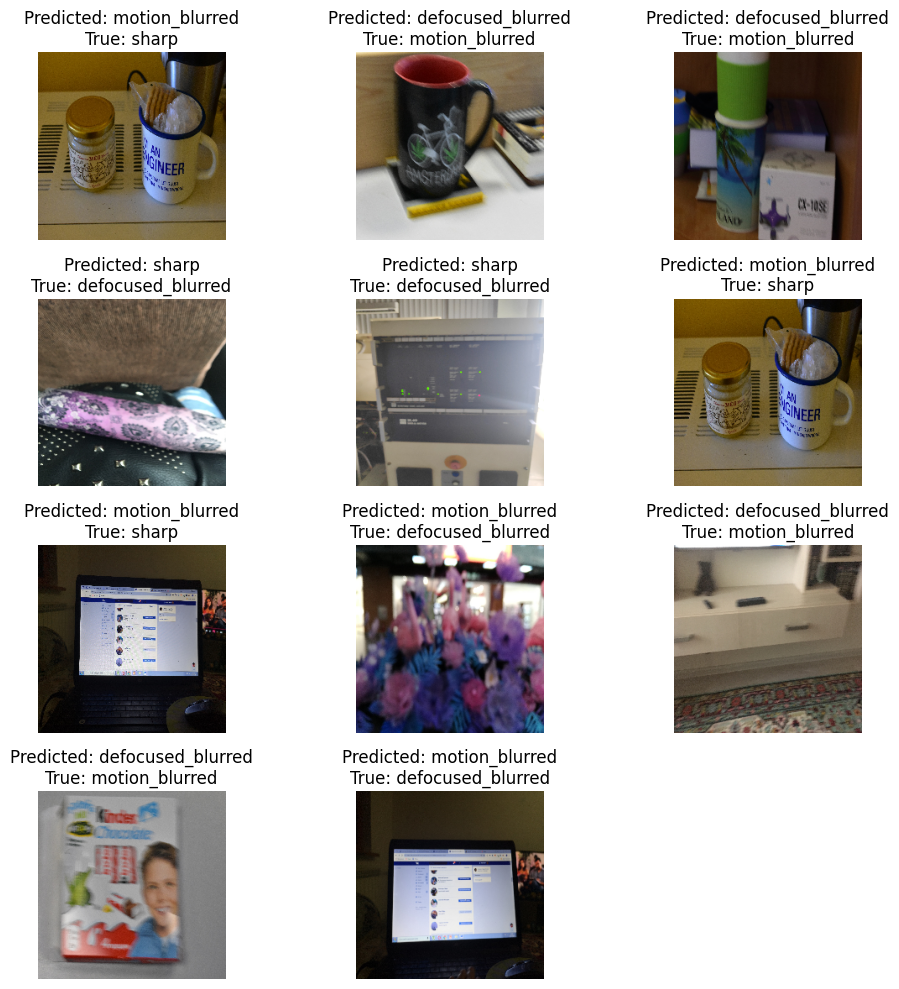

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

errate = 0
total_images = 0
batch_size = test_generator.batch_size
total_batches = len(test_generator)

misclassified_images = []
misclassified_predicted_labels = []
misclassified_true_labels = []

true_labels_all = []
predicted_labels_all = []

for batch_index, (images, labels) in enumerate(test_generator):
    predictions = model9.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    true_labels_all.extend(true_labels)
    predicted_labels_all.extend(predicted_labels)

    misclassified_indices = np.where(predicted_labels != true_labels)[0]
    misclassified_images.extend(images[misclassified_indices])
    misclassified_predicted_labels.extend(predicted_labels[misclassified_indices])
    misclassified_true_labels.extend(true_labels[misclassified_indices])

    errate += np.sum(predicted_labels != true_labels)
    total_images += len(images)
    print(total_images)
    if batch_index + 1 >= total_batches:  # interrompi il ciclo quando il numero di batch raggiunge la fine
        break

print("Numero di immagini classificate erroneamente:", errate)
print("Numero totale di immagini:", total_images)

# Calcola il classification report
report = classification_report(true_labels_all, predicted_labels_all)
print(report)

# Visualizza la matrice di confusione
conf_matrix = confusion_matrix(true_labels_all, predicted_labels_all)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Visualizza le immagini classificate erroneamente
num_misclassified = len(misclassified_images)
num_rows = int(np.ceil(np.sqrt(num_misclassified)))
num_cols = int(np.ceil(num_misclassified / num_rows))

blur_images = class_labels  # Sostituisci con i nomi delle classi corrette

plt.figure(figsize=(10, 10))
for i, (image, predicted_label, true_label) in enumerate(zip(misclassified_images, misclassified_predicted_labels, misclassified_true_labels)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(np.clip(image * 255.0, 0, 255).astype('uint8'))
    plt.title(f"Predicted: {blur_images[predicted_label]}\nTrue: {blur_images[true_label]}")  # Aggiungi l'etichetta predetta e vera nel titolo
    plt.axis('off')

plt.tight_layout()
plt.show()
